**Introduction**

November 30th, 2022, stands as a pivotal moment in the history of machine learning. On that day, OpenAI unveiled ChatGPT, establishing a groundbreaking standard for chatbots fueled by Large Language Models and providing the public with an unmatched conversational experience

Since then, large language models (often abbreviated as LLMs) have captured public attention due to their remarkable versatility across a wide range of tasks.

In this Notebook we are going to summarize news articles by using the bbc-news-summary dataset. The dataset are structured into a specific 'File Path', 'Article', and ' Highlights'

**The Model**

In [ ]:
# ! pip install transformers
! pip install datasets
! pip install sentencepiece
! pip install rouge_score

In [ ]:
!pip install transformers[torch] -q

In [ ]:
import os
os.environ["WANDB_MODE"] = "dryrun"

In [ ]:
import torch
import numpy as np
import datasets
from datasets import load_dataset, load_metric
from transformers import (
    AutoModelForSeq2SeqLM,
    AutoTokenizer,
    AutoModel,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    DataCollatorForSeq2Seq,
    pipeline
)

from tabulate import tabulate
import nltk
from datetime import datetime

# Importing model

In [ ]:
model_name = "vinai/bartpho-syllable"
model = AutoModelForSeq2SeqLM.from_pretrained("vinai/bartpho-syllable")
tokenizer = AutoTokenizer.from_pretrained("vinai/bartpho-syllable")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
encoder_max_length = 256  # demo
decoder_max_length = 64

# Preparing dataset

In [ ]:
from datasets import load_dataset
#https://huggingface.co/datasets/gopalkalpande/bbc-news-summary

dataset = load_dataset("Pnguins/VnExpress_edu")

Generating train split:   0%|          | 0/6140 [00:00<?, ? examples/s]

In [ ]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'full text', 'Summary'],
        num_rows: 6140
    })
})


In [ ]:
for k,v in dataset["train"][0].items():
  print(k)
  print(v)

Unnamed: 0
0
full text
Thủ tướng Nguyễn Xuân Phúc và Bộ trưởng Ngoại giao Nhật Bản Taro Kono - Ảnh: VGP/Quang Hiếu.
Tại buổi tiếp, Thủ tướng Nguyễn Xuân Phúc bày tỏ vui mừng trước sự phát triển nhanh chóng, thực chất và toàn diện của quan hệ Đối tác chiến lược sâu rộng Việt Nam - Nhật Bản; cho rằng việc hai nước đẩy mạnh trao đổi và tiếp xúc đoàn cấp cao thời gian qua đã giúp tăng cường sự tin cậy- điều kiện quan trọng để thúc đẩy quan hệ Việt Nam - Nhật Bản phát triển hơn nữa trên mọi lĩnh vực; mong muốn tăng cường hợp tác ASEAN - Nhật Bản và Mekong - Nhật Bản, nhất là khi Việt Nam đảm nhiệm vai trò Điều phối viên quan hệ ASEAN - Nhật Bản giai đoạn 2018 - 2021; đánh giá cao Nhật Bản đã cung cấp vốn hỗ trợ phát triển chính thức ODA cho Việt Nam thời gian qua, khẳng định Chính phủ Việt Nam coi trọng và nỗ lực thực hiện hiệu quả các dự án vốn vay ODA giữa hai nước.
Ảnh: VGP/Quang Hiếu.
Thủ tướng Nguyễn Xuân Phúc đề nghị Bộ trưởng Ngoại giao Nhật Bản quan tâm thúc đẩy liên kết kinh tế giữ

In [ ]:
def flatten(example):
    return {
        "Content": example["full text"],
        "Summary": example["Summary"],
    }

dataset = dataset["train"].map(flatten, remove_columns=["Unnamed: 0"])

Map:   0%|          | 0/6140 [00:00<?, ? examples/s]

In [ ]:
print(dataset)

Dataset({
    features: ['full text', 'Summary', 'Content'],
    num_rows: 6140
})


In [ ]:
article_len = [len(x['full text'].split()) for x in dataset]
highlights_len = [len(x['Summary'].split()) for x in dataset]

array([[<Axes: title={'center': 'article Length'}>,
        <Axes: title={'center': 'highlights Length'}>]], dtype=object)

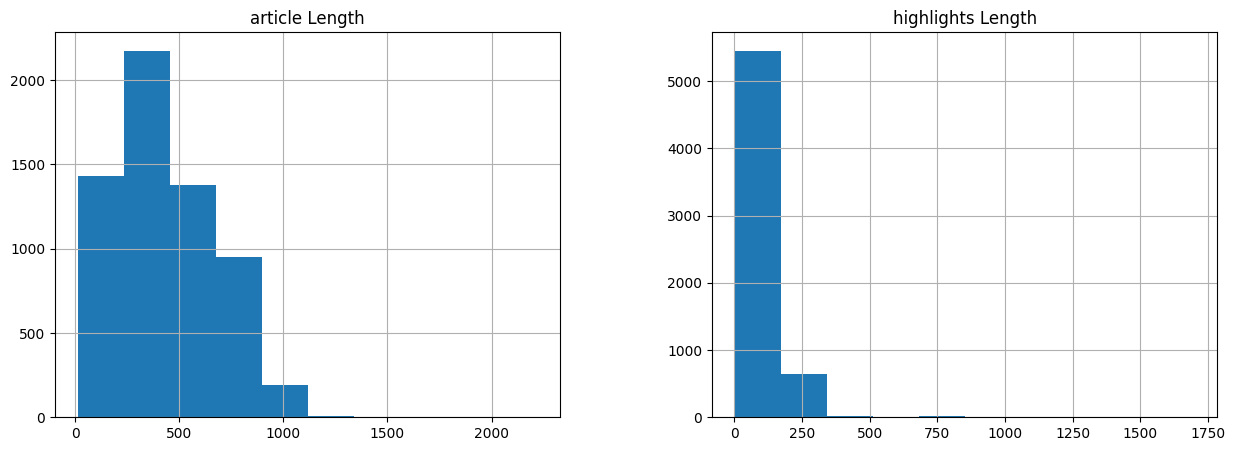

In [ ]:
import pandas as pd

data = pd.DataFrame([article_len, highlights_len]).T
data.columns = ['article Length', 'highlights Length']

data.hist(figsize=(15,5))

In [ ]:
import datasets
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=5):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)

    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, datasets.ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    display(HTML(df.to_html()))

In [ ]:
show_random_elements(dataset)

,full text,Summary,Content
0,">> Tình hình bạo động tại Brazil lắng dịu Ngày 28/11 (theo giờ địa phương), cảnh sát quân sự Brazil, với sự hỗ trợ của các binh sĩ lục quân và lính thủy đánh bộ được trang bị xe bọc thép, đã chiếm lại một khu ổ chuột lớn tại thành phố Rio de Janeiro. Đây là thành phố lớn nhất của nước này, nơi sẽ diễn ra hai sự kiện thể thao lớn của thế giới là World Cup 2014 và Olympic 2016. Các lực lượng an ninh Brazil đang tiến hành kiểm tra trong từng ngôi nhà tại khu ổ chuột Alemao để truy lùng những thành viên các băng đảng ma túy đứng sau làn sóng bạo lực kéo dài một tuần qua tại thành phố biển Rio de Janeiro, làm ít nhất 46 người chết và hơn 100 chiếc xe bị đốt cháy. Phát biểu tại cuộc họp báo rạng sáng 29/11 (theo giờ Việt Nam), Bộ trưởng An ninh bang Rio, ông Jose Mariano Bentrame, thừa nhận cuộc chiến chống ma túy tại bang này vẫn còn rất khó khăn. Ông Bentrame nói: Chúng tôi vẫn chưa giành thắng lợi trong cuộc chiến này. Còn rất nhiều vấn đề chưa được giải quyết. Chặng đường vẫn còn dài với rất nhiều việc phải làm, nhưng chúng tôi đã tiến được một bước quan trọng. Alemao là trung tâm của hoạt động tội phạm. Nó là biểu tượng của bạo lực tại thành phố Riode Janeiro, nơi tập trung phần lớn tội phạm. Kết quả hôm nay, tôi nghĩ là một chiến công quan trọng của cảnh sát và là một thất bại lớn của tội phạm, nhất là về mặt tâm lý. Trong chiến dịch truy lùng tội phạm tại khu ổ chuột Alemao, cảnh sát đã thu giữ số lượng lớn vũ khí và hàng tấn ma túy. Trong số những thành viên các băng đảng ma túy bị săn lùng ở khu ổ chuột này có cả những tên đã bỏ trốn khỏi khu ổ chuột Vila Cruzeiro tuần trước sau khi bị cảnh sát tấn công. Việc kiểm soát thành công cả hai khu ổ chuột khét tiếng này được đánh giá là bước ngoặt trong chiến dịch an ninh của các cơ quan chức năng Brazil tại thành phố du lịch được coi là thiên đường tội phạm ma túy của nước này, đặc biệt là trong quá trình chuẩn bị đăng cai hai sự kiện thể thao lớn nhất thế giới như World Cup 2014 và Olympic 2016./. Tuấn Anh (theo Reuters).\n","Cảnh sát quân sự Brazil với sự hỗ trợ của các binh sĩ lục quân và lính thủy đã chiếm lại một khu ổ chuột lớn tại thành phố Rio de Janeiro. Đây là thành phố lớn nhất của nước này, nơi sẽ diễn ra hai sự kiện thể thao lớn của thế giới là World Cup 2014 và Olympic 2016. Các lực lượng an ninh Brazil đang tiến hành kiểm tra trong từng ngôi nhà tại khu ổ chuột Alemao để truy lùng những thành viên các băng đảng ma túy. Kết quả hôm nay, cảnh sát đã thu giữ số lượng lớn vũ khí và hàng tấn ma túy. Việc kiểm soát thành công cả hai khu ổ chuột khét tiếng này được đánh giá là bước ngoặt trong chiến dịch an ninh của các cơ quan chức năng Brazil tại thành phố du lịch Rio de Janeiro.",">> Tình hình bạo động tại Brazil lắng dịu Ngày 28/11 (theo giờ địa phương), cảnh sát quân sự Brazil, với sự hỗ trợ của các binh sĩ lục quân và lính thủy đánh bộ được trang bị xe bọc thép, đã chiếm lại một khu ổ chuột lớn tại thành phố Rio de Janeiro. Đây là thành phố lớn nhất của nước này, nơi sẽ diễn ra hai sự kiện thể thao lớn của thế giới là World Cup 2014 và Olympic 2016. Các lực lượng an ninh Brazil đang tiến hành kiểm tra trong từng ngôi nhà tại khu ổ chuột Alemao để truy lùng những thành viên các băng đảng ma túy đứng sau làn sóng bạo lực kéo dài một tuần qua tại thành phố biển Rio de Janeiro, làm ít nhất 46 người chết và hơn 100 chiếc xe bị đốt cháy. Phát biểu tại cuộc họp báo rạng sáng 29/11 (theo giờ Việt Nam), Bộ trưởng An ninh bang Rio, ông Jose Mariano Bentrame, thừa nhận cuộc chiến chống ma túy tại bang này vẫn còn rất khó khăn. Ông Bentrame nói: Chúng tôi vẫn chưa giành thắng lợi trong cuộc chiến này. Còn rất nhiều vấn đề chưa được giải quyết. Chặng đường vẫn còn dài với rất nhiều việc phải làm, nhưng chúng tôi đã tiến được một bước quan trọng. Alemao là trung tâm của hoạt động tội phạm. Nó là biểu tượng của bạo lực tại thành phố Riode Janeiro, nơi tập trung phần lớn tội phạm. Kết quả hôm nay, tôi nghĩ là một chiến công quan trọng của cảnh sát và l

In [ ]:
def list2samples(example):
    documents = []
    summaries = []
    documents += example["Content"]
    summaries += example["Summary"]
    return {"Content": documents, "Summary": summaries}


dataset = dataset.map(list2samples, batched=True)

train_data_txt, validation_data_txt = dataset.train_test_split(test_size=0.1).values()
# Split the validation dataset into validation and test sets
validation_data_txt, test_data_txt = validation_data_txt.train_test_split(test_size=0.5).values()

Map:   0%|          | 0/6140 [00:00<?, ? examples/s]

In [ ]:
print("Training dataset size:", len(train_data_txt))
print("Validation dataset size:", len(validation_data_txt))
print("Test dataset size:", len(test_data_txt))

Training dataset size: 5526
Validation dataset size: 307
Test dataset size: 307


In [ ]:
validation_data_txt[0]

{'full text': 'Cuộc họp giữa cơ quan chức năng TPHCM với Tập đoàn Quang Trung.\nBồi thường 2 tỷ đồng nếu thất bại.\nNgày 24/6, tại cuộc họp với đại diện Sở Giao thông Vận tải TPHCM, Sở Tài chính; Sở Nông nghiệp và Phát triển nông thôn; Thành ủy TP HCM.., Bí thư Thành ủy TPHCM Nguyễn Thiện Nhân đã chấp nhận phương án thử nghiệm chống ngập bằng máy thông minh do Tập đoàn Công nghiệp Quang Trung chế tạo.\nTheo đó, máy bơm thông minh này sẽ được đặt thử nghiệm tại đường Nguyễn Hữu Cảnh, quận Bình Thạnh, TPHCM.\nTại cuộc họp, ông Nguyễn Thiện Nhân đề nghị các sở, ngành của TPHCM phối hợp với Tập đoàn Quang Trung để tiến hành việc đặt máy bơm thông minh.\nNgoài ra, Bí thư Thành ủy TPHCM cũng đề nghị Tập đoàn Quang Trung cần cẩn trọng đề cập các phương án đảm bảo an toàn đối với hệ thống cống thoát nước khi máy bơm vận hành công suất lớn.\nBí thư Thành ủy đánh giá cao nỗ lực của doanh nhân Nguyễn Tăng Cường, Tổng giám đốc Tập đoàn Quang Trung, cũng như lời hứa của ông Cường "không hết ngập kh

In [ ]:
def batch_tokenize_preprocess(batch, tokenizer, max_source_length, max_target_length):
    source, target = batch["Content"], batch["Summary"]
    source_tokenized = tokenizer(
        source, padding="max_length", truncation=True, max_length=max_source_length
    )
    target_tokenized = tokenizer(
        target, padding="max_length", truncation=True, max_length=max_target_length
    )

    batch = {k: v for k, v in source_tokenized.items()}
    # Ignore padding in the loss
    batch["labels"] = [
        [-100 if token == tokenizer.pad_token_id else token for token in l]
        for l in target_tokenized["input_ids"]
    ]
    return batch


train_data = train_data_txt.map(
    lambda batch: batch_tokenize_preprocess(
        batch, tokenizer, encoder_max_length, decoder_max_length
    ),
    batched=True,
    remove_columns=train_data_txt.column_names,
)

validation_data = validation_data_txt.map(
    lambda batch: batch_tokenize_preprocess(
        batch, tokenizer, encoder_max_length, decoder_max_length
    ),
    batched=True,
    remove_columns=validation_data_txt.column_names,
)
# test_data = test_data_txt.map(
#     lambda batch: batch_tokenize_preprocess(
#         batch, tokenizer, encoder_max_length, decoder_max_length
#     ),
#     batched=True,
#     remove_columns=test_data_txt.column_names,
# )

Map:   0%|          | 0/5526 [00:00<?, ? examples/s]

Map:   0%|          | 0/307 [00:00<?, ? examples/s]

# Training

In [ ]:
nltk.download("punkt", quiet=True)

metric = datasets.load_metric("rouge")


def postprocess_text(preds, labels):
    preds = [pred.strip() for pred in preds]
    labels = [label.strip() for label in labels]

    # rougeLSum expects newline after each sentence
    preds = ["\n".join(nltk.sent_tokenize(pred)) for pred in preds]
    labels = ["\n".join(nltk.sent_tokenize(label)) for label in labels]

    return preds, labels


def compute_metrics(eval_preds):
    preds, labels = eval_preds
    if isinstance(preds, tuple):
        preds = preds[0]
    decoded_preds = tokenizer.batch_decode(preds, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)

    # Some simple post-processing
    decoded_preds, decoded_labels = postprocess_text(decoded_preds, decoded_labels)

    result = metric.compute(
        predictions=decoded_preds, references=decoded_labels, use_stemmer=True
    )
    # Extract a few results from ROUGE
    result = {key: value.mid.fmeasure * 100 for key, value in result.items()}

    prediction_lens = [
        np.count_nonzero(pred != tokenizer.pad_token_id) for pred in preds
    ]
    result["gen_len"] = np.mean(prediction_lens)
    result = {k: round(v, 4) for k, v in result.items()}
    return result

/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for rouge contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/rouge/rouge.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [ ]:
training_args = Seq2SeqTrainingArguments(
    output_dir="results",
    num_train_epochs=3,  # demo
    do_train=True,
    do_eval=True,
    per_device_train_batch_size=4,  # demo
    per_device_eval_batch_size=4,
    # learning_rate=3e-05,
    warmup_steps=500,
    weight_decay=0.1,
    label_smoothing_factor=0.12,
    predict_with_generate=True,
    logging_dir="logs",
    logging_steps=50,
    save_total_limit=3,
)

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=train_data,
    eval_dataset=validation_data,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.evaluate()

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1168: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


{'eval_loss': 5.088360786437988,
 'eval_rouge1': 31.4764,
 'eval_rouge2': 18.139,
 'eval_rougeL': 25.035,
 'eval_rougeLsum': 27.5033,
 'eval_gen_len': 20.0,
 'eval_runtime': 54.6071,
 'eval_samples_per_second': 5.622,
 'eval_steps_per_second': 1.41}

In [ ]:
trainer.train()

Step,Training Loss
50,5.488500
100,3.704300
150,3.316500
200,3.221000
250,3.188900
300,2.988300
350,3.001400
400,2.999800
450,2.851900
500,2.894700


Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'forced_eos_token_id': 2}
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-defau

TrainOutput(global_step=4146, training_loss=2.5438708182526737, metrics={'train_runtime': 3925.2579, 'train_samples_per_second': 4.223, 'train_steps_per_second': 1.056, 'total_flos': 8981669323210752.0, 'train_loss': 2.5438708182526737, 'epoch': 3.0})

In [ ]:
# import shutil
# import os

# # Define the folder you want to zip
# folder_to_zip = "/content/results/checkpoint-5000"

# # Define the name for the zip file
# zip_file_name = "bart.zip"

# # Define the path where you want to save the zip file
# zip_destination = "/content"

# # Create a full path for the zip file
# zip_file_path = os.path.join(zip_destination, zip_file_name)

# # Create the zip file
# shutil.make_archive(zip_file_path[:-4], 'zip', folder_to_zip)

# # Optional: If you want to delete the original folder after zipping
# shutil.rmtree(folder_to_zip)

# # Check if the zip file is created successfully
# if os.path.exists(zip_file_path):
#     print(f"Folder '{folder_to_zip}' zipped successfully as '{zip_file_path}'")
# else:
#     print("Failed to create zip file.")


In [ ]:
trainer.save_model("Bart-vnexpress-model")

Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'forced_eos_token_id': 2}


In [ ]:
## Save tokenizer
tokenizer.save_pretrained("tokenizer")

('tokenizer/tokenizer_config.json',
 'tokenizer/special_tokens_map.json',
 'tokenizer/sentencepiece.bpe.model',
 'tokenizer/dict.txt',
 'tokenizer/added_tokens.json')

# Inference

In [ ]:
def generate_summary(test_samples, model):
    inputs = tokenizer(
        test_samples["Content"],
        padding="max_length",
        truncation=True,
        max_length=encoder_max_length,
        return_tensors="pt",
    )
    input_ids = inputs.input_ids.to(model.device)
    attention_mask = inputs.attention_mask.to(model.device)
    outputs = model.generate(input_ids, attention_mask=attention_mask, max_length=512)
    output_str = tokenizer.batch_decode(outputs, skip_special_tokens=True)
    return outputs, output_str


model_before_tuning = AutoModelForSeq2SeqLM.from_pretrained(model_name)

test_samples = test_data_txt.select(range(2))

summaries_before_tuning = generate_summary(test_samples, model_before_tuning)[1]
summaries_after_tuning = generate_summary(test_samples, model)[1]

In [ ]:
print(
    tabulate(
        zip(
            range(len(summaries_after_tuning)),
            summaries_after_tuning,
            summaries_before_tuning,
        ),
        headers=["Id", "Summary after", "Summary before"],
    )
)
print("\nTarget summaries:\n")
print(
    tabulate(list(enumerate(test_samples["Summary"])), headers=["Id", "Target summary"])
)
print("\nSource documents:\n")
print(tabulate(list(enumerate(test_samples["Content"])), headers=["Id", "Document"]))

  Id  Summary after                                                                 Summary before
----  ----------------------------------------------------------------------------  --------------------------------------------------------------------------
   0  Công an TP Hà Nội đề nghị Bộ Công an nâng cấp Phòng Cảnh sát PCCC             Công an TP Hà Nội cho rằng trong mô hình hiện tại, cảnh sát PCCC
   1  Elon Musk là một trong những người thành công nhất trong lĩnh vực công nghệ.  Thiên tài lập dị Elon Musk. Chúng ta thường thích nghe lời khuyên từ những

Target summaries:

  Id  Target summary
----  ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# custome Dialogue Prediction

pipe = pipeline('summarization', model="Bart-vnexpress-model")
gen_kwargs = {'length_penalty': 0.8, 'num_beams': 8, "max_length": 256}

custom_dialogue="""
Pháp hiện có hơn 3.500 trường đào tạo đa ngành, nghề, với lợi thế là chi phí rẻ.
Thống kê năm 2023 của tổ chức xếp hạng THE cho thấy để du học Mỹ, sinh viên quốc tế cần khoảng 30.000-90.000 USD (764 triệu-2,3 tỷ đồng) một năm. Mức này ở Australia là 41.000-61.000 AUD (690 triệu-1 tỷ đồng), trong khi ở Pháp chỉ hơn 7.550-27.000 euro (200 triệu-700 triệu đồng).
Về chất lượng, nước này có 38 trường trong bảng xếp hạng thế giới của QS 2024, trong đó có 4 trường lọt top 100. Pháp cũng nổi tiếng với hệ thống trường lớn (Grande Ecole) - mô hình đặc biệt nhằm tuyển chọn và đào tạo chuyên gia về kinh tế, khoa học, kỹ thuật, chính trị...
Thạc sĩ Nguyễn Việt Anh, phó giám đốc VFE, tổ chức Giáo dục và Du học Pháp tại Việt Nam, cho biết chi phí du học chủ yếu gồm tiền học và sinh hoạt phí.
Nhưng nếu trúng tuyển vào trường công, phần lớn du học sinh được miễn học phí, chỉ cần đóng phí ghi danh, khoảng 170-2.770 euro (4,6 đến 76 triệu đồng một năm), tùy trường. Nếu học tư thục, tiền học khoảng 5.000-20.000 euro (138-550 triệu đồng) mỗi năm.
Với chi phí sinh hoạt, sinh viên phải có ít nhất 7.380 euro (200 triệu đồng) như yêu cầu của đại sứ quán khi xin thị thực. Theo một khảo sát gần đây của VFE, mỗi du học sinh cần khoảng 460-615 euro một tháng. Trong đó, tiền thuê nhà chiếm nhiều nhất - khoảng một nửa hoặc hơn.
Để trang trải, du học sinh có thể tìm đến Quỹ trợ cấp nhà ở của chính phủ Pháp (CAF) và làm thêm.
Bà Việt Anh cho hay CAF hỗ trợ một phần (20-50%) tiền thuê nhà cho hầu hết sinh viên quốc tế, từ hệ cử nhân, dự bị tiếng, học bằng tiếng Anh hay tiếng Pháp. "Bạn cần điền đơn trực tuyến để nhận được khoản này mỗi tháng. CAF sẽ chuyển tiền về tài khoản của sinh viên hoặc chuyển thẳng cho chủ nhà", bà nói.
Ngoài ra, Pháp cho phép sinh viên quốc tế làm thêm 20 giờ mỗi tuần trong thời gian học, 35 giờ trong kỳ nghỉ lễ. Những công việc du học sinh thường làm là rửa bát, phụ bếp, bồi bàn... Nếu tiếng Pháp tốt, họ có thể làm nhân viên bán hàng, thu ngân hay hỗ trợ người già, gia sư. Lương làm thêm trung bình khoảng 9 euro một giờ.
Tăng Văn Minh, sinh viên năm thứ hai ngành Thiết kế không gian tại thành phố Toulouse, cho hay mỗi tháng cần tiêu khoảng 500-550 euro (14-15 triệu đồng), đã gồm tiền ăn. Đây là mức trung bình của du học sinh ở Pháp.
Minh được CAF hỗ trợ 30% nên chỉ còn phải đóng khoảng 250-300 euro mỗi tháng tiền thuê nhà. Ngoài ra, nam sinh làm phục vụ trong nhà hàng hoặc công việc khác.
"Trong kỳ học, mình có thể kiếm đủ để chi tiêu, dư một ít, còn vào mùa hè làm toàn thời gian có thể kiếm hơn 1.000 euro một tháng", Minh cho hay.
Về cơ hội việc làm sau khi ra trường, tiến sĩ Nguyễn Đăng Hanh, giảng viên Đại học Xây dựng Ecole Builders, cho biết du học sinh được ở lại 12 đến 18 tháng. Họ có thể làm cho các công ty, tập đoàn với mức lương trung bình 2.200-3.100 euro mỗi tháng. Làm việc 3 năm và không vi phạm pháp luật, sinh viên nước ngoài đủ điều kiện xin quốc tịch.
"Bằng đại học của Pháp cũng có giá trị quốc tế nên sinh viên còn có thể tìm việc ở các nước châu Âu", ông Hanh nhận định.
Nếu định du học Pháp, học sinh nên cố gắng đạt kết quả học tập (GPA) tốt ở THPT để có lợi thế khi ứng tuyển vào các đại học ở đây. Theo bà Việt Anh, các trường thường yêu cầu GPA từ 7, chứng chỉ tiếng Pháp TCF 400 hoặc DELF B2, IELTS 6.0 trở lên.
Ngoài ra, các trường khắt khe trong đánh giá. Bài thi các môn phần lớn diễn ra trực tiếp hoặc vấn đáp, đòi hỏi sự học tập thường xuyên, hiểu về bản chất môn học và tổng hợp thông tin tốt.
"Việc làm thêm ở Pháp hấp dẫn nên sinh viên cần tỉnh táo, không quên nhiệm vụ chính là học tập", bà nói.
Theo nhiều thống kê, Pháp xếp thứ 6 về số sinh viên quốc tế, với hơn 412.000 người vào năm học trước. Trong đó, du học sinh Việt khoảng 6.000.
"""
print(pipe(custom_dialogue, **gen_kwargs))

[{'summary_text': 'Pháp hiện có hơn 3.500 trường đào tạo đa ngành, nghề với lợi thế là chi phí rẻ. Thạc sĩ Nguyễn Việt Anh, phó giám đốc VFE, tổ chức Giáo dục và Du học Pháp tại Việt Nam, cho biết chi phí du học chủ yếu gồm tiền học và sinh hoạt phí.'}]


**Inference Summary:**




**Possible Summary:**



# Daily summary

In [ ]:
import pandas as pd
vn = pd.read_csv("today.csv")

In [ ]:
vn

,Unnamed: 0,Title,Content,Date
0,5,'Đại học cần dạy sinh viên khả năng làm công v...,Trường Đại học Thăng Long vừa công bố bộ nhận ...,2024-05-31
1,8,Chàng trai Việt tốt nghiệp xuất sắc ở đại học ...,"Đỗ Khanh, 32 tuổi, người TP HCM, hiện là giám ...",2024-05-31
2,20,TP HCM xem xét đóng cửa trường Quốc tế Mỹ,"Chiều 31/5, ông Hồ Tấn Minh, Chánh Văn phòng S...",2024-05-31
3,22,7 học sinh Việt giành huy chương Olympic Tin h...,Theo thông báo sáng 31/5 của Bộ Giáo dục và Đà...,2024-05-31
4,23,CEO 9X giành học bổng tiến sĩ luật 80.000 USD ...,"Nguyễn Hoàng Huy, 30 tuổi, sinh ra và lớn lên ...",2024-05-31
5,34,Tân sinh viên Hoa Sen được đi trải nghiệm nước...,Hoa Sen Go Global là chương trình trải nghiệm ...,2024-05-31
6,36,MC Minh Trang làm đại sứ ứng dụng học tiếng An...,"Nguyễn Minh Trang là MC, nhà sáng lập của Hộp ...",2024-05-31


In [ ]:
vn = vn.drop(vn[vn["Content"].str.len() < 50].index)

In [ ]:
print((len(vn)))

7


In [ ]:
for i in range(len(vn)):
  print(i)
  print(generate_summary(vn.iloc[i], model)[1])

0
['Trường Đại học Thăng Long vừa công bố bộ nhận diện thương hiệu mới với ba màu sắc chính: xanh dương, đỏ, trắng, với những khối hình kỷ hà, bộ chữ độc quyền "Thang Long Sans". Bộ nhận diện này được xây dựng trên nền tảng bốn giá trị cốt lõi']
1
['Đỗ Khanh, một thạc sĩ Chính sách công (MPP) của Đại học Oxford, đã tốt nghiệp thạc sĩ Chính sách công (MPP) năm 2017. Anh đã được miễn học phí tại Anh và nhận bằng tú tài Anh ( B) sau khi tốt nghiệp. Anh đã tham gia']
2
['Sở Giáo dục và Đào tạo TP.HCM đã đình chỉ hoạt động của AISVN trong 12 tháng, để đảm bảo đủ đội ngũ nhà giáo, cán bộ quản lý và nguồn lực tài chính. AISVN hiện chưa đáp ứng được hai tiêu chí này, vì vậy học sinh bắt buộc phải chuyển']
3
['Kỳ thi Olympic Tin học châu Á - Thái Bình Dương lần thứ 18 đã diễn ra trong hai ngày 18-19/5 với gần 290 thí sinh của 35 đoàn. Việt Nam có 15 học sinh, thi trực tuyến tại trường Đại học Công nghệ (UET), Đại học Quốc gia Hà Nội và giành huy chương']
4
['Nguyễn Hoàng Huy là một trong những 